In [73]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from sksurv.compare import compare_survival

from sklearn.model_selection import train_test_split
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored
from sksurv.metrics import concordance_index_ipcw
from sksurv.metrics import brier_score

In [96]:
file_path = './survival_results'
train_df_control = pd.read_csv('./placebo_both_clinic_gene_data_for_training_after_merged.csv', index_col=0)
gene_exp = train_df_control.iloc[:, :-10] #gene exp
y = train_df_control.iloc[:, -10:] #survival time and event

print(gene_exp.shape, y.shape)

clinical_val = train_df_control[['Menospausal Status', 'Age', 'Risk Group']]
survival_val = train_df_control[['USI','Time to event if any (days)','IDFS Event']]
print(clinical_val.shape, survival_val.shape)
print(y.columns)

gene_names = pd.read_csv(file_path + '/significant_gene_names.csv')
gene_names = gene_names['gene'].tolist()
print(gene_names)

selected_genes = gene_exp[gene_names]
print(selected_genes.shape)

for_scale = pd.concat([selected_genes,clinical_val['Age']],axis=1)
print(for_scale.shape)

(150, 19447) (150, 10)
(150, 3) (150, 3)
Index(['USI', 'RNA Batch', 'Treatment Arm', 'Menospausal Status', 'Age',
       'Allocation', 'Risk Group', 'IDFS Event', 'Duration of followup (days)',
       'Time to event if any (days)'],
      dtype='object')
['SERINC1', 'WDR6', 'INTS3', 'PIP5K1A', 'TMEM259', 'ARGLU1', 'NXF1', 'SNX3', 'KAT2A', 'CLCN7', 'AHCY', 'CSNK1D', 'ELK3', 'SLC25A28', 'DELE1', 'ABHD12', 'PARP4', 'SLA', 'SPPL2B', 'NREP', 'RANBP9', 'BCL2L1', 'LGALS3BP', 'FKBP8', 'YPEL3', 'WWC3', 'KIF5B', 'CBX1', 'JADE2', 'UBE2J1', 'ZNF692', 'RESF1', 'TRAF1', 'CCND1', 'PCP2', 'SLC25A23', 'HERPUD1', 'KLF10', 'SUGP2', 'PFKL', 'GGA3', 'ARHGAP40', 'PCNA', 'SRSF1', 'C1QA', 'SETDB1', 'CPNE1', 'MCFD2', 'SET', 'SF3B6', 'TEP1', 'GNAQ', 'TUBG2', 'ITGB1', 'NPIPB5', 'PRKD2', 'MTPN', 'ZFYVE27', 'RPL10', 'MGRN1', 'CTTN', 'ENC1', 'PCYOX1', 'TTC9', 'RPS5', 'CD164', 'CSGALNACT2', 'HOOK2', 'NCOA5', 'ACTR2', 'PLK2', 'TMEM140', 'CLIC1', 'IFITM2', 'TMEM101', 'ATP1B1', 'CABIN1', 'NPIPB3', 'RAB11FIP1', 'UBAP2L'

In [97]:
# check sparsity: 0.5 as a general rule of thumb: a matrix with sparsity greater than 0.5 is often considered sparse.
df = gene_exp.copy()
total_zeroes = (df == 0).sum().sum()
total_el = df.size
sparsity = total_zeroes/total_el * 100
print(f'sparsity is totally {sparsity}% among matrix')

selected_df = selected_genes.copy()
total_zeroes = (selected_df == 0).sum().sum()
total_el = selected_df.size
sparsity = total_zeroes/total_el * 100
print(f'sparsity is totally {sparsity}% among selected genes matrix')

sparsity is totally 26.83601583791845% among matrix
sparsity is totally 1.2672176308539946% among selected genes matrix


## 1. prepare scikit-survival format

X: feature, clinical variables + kept genes

In [98]:
from sksurv.util import Surv

y_structured = Surv.from_arrays(
    event=y['IDFS Event'].values.astype(bool),
    time=y['Time to event if any (days)'].values
)
# lifelines_df = pd.concat([selected_genes, y], axis=1) ## the feature should be the selected genes

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
selected_genes_scaled = pd.DataFrame(scaler.fit_transform(selected_genes), columns=selected_genes.columns, index = selected_genes.index)

age_gene_scaled = pd.DataFrame(scaler.fit_transform(for_scale), columns=for_scale.columns, index=for_scale.index)

X = pd.concat([age_gene_scaled, clinical_val[['Risk Group','Menospausal Status']]],axis=1)
X = pd.get_dummies(X, columns=['Menospausal Status','Risk Group'], drop_first=True)
print(X.columns)

Index(['SERINC1', 'WDR6', 'INTS3', 'PIP5K1A', 'TMEM259', 'ARGLU1', 'NXF1',
       'SNX3', 'KAT2A', 'CLCN7',
       ...
       'LRRC56', 'OGT', 'EEF1D', 'USP36', 'MZF1', 'Age',
       'Menospausal Status_Pre-Menopausal', 'Risk Group_2.0', 'Risk Group_3.0',
       'Risk Group_4.0'],
      dtype='object', length=126)


In [99]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_structured, test_size=0.3, random_state=100, stratify=y_structured['event']
)

print('log-rank test for survival curve')
y_all = np.concatenate([y_train, y_test])
group_labels = np.array(['training'] * len(y_train) + ['testing'] * len(y_test))
results = compare_survival(y_all, group_labels)
print(f'log-rank test statistic, p-value: {results}')

print("--- training set distribution ---")
event_counts_train = np.bincount(y_train['event'])
print(event_counts_train)
print(f"False: {event_counts_train[0]}, True: {event_counts_train[1]}")
print(f"event(happen) rate: {event_counts_train[1] / len(y_train) * 100:.2f}%")

print("\n--- testing set distribution ---")
event_counts_test = np.bincount(y_test['event'])
print(event_counts_test)
print(f"False: {event_counts_test[0]}, True: {event_counts_test[1]}")
print(f"event(happen) rate: {event_counts_train[1] / len(y_train) * 100:.2f}%")

log-rank test for survival curve
log-rank test statistic, p-value: (np.float64(0.015335970039748107), np.float64(0.9014431607585323))
--- training set distribution ---
[81 24]
False: 81, True: 24
event(happen) rate: 22.86%

--- testing set distribution ---
[35 10]
False: 35, True: 10
event(happen) rate: 22.86%


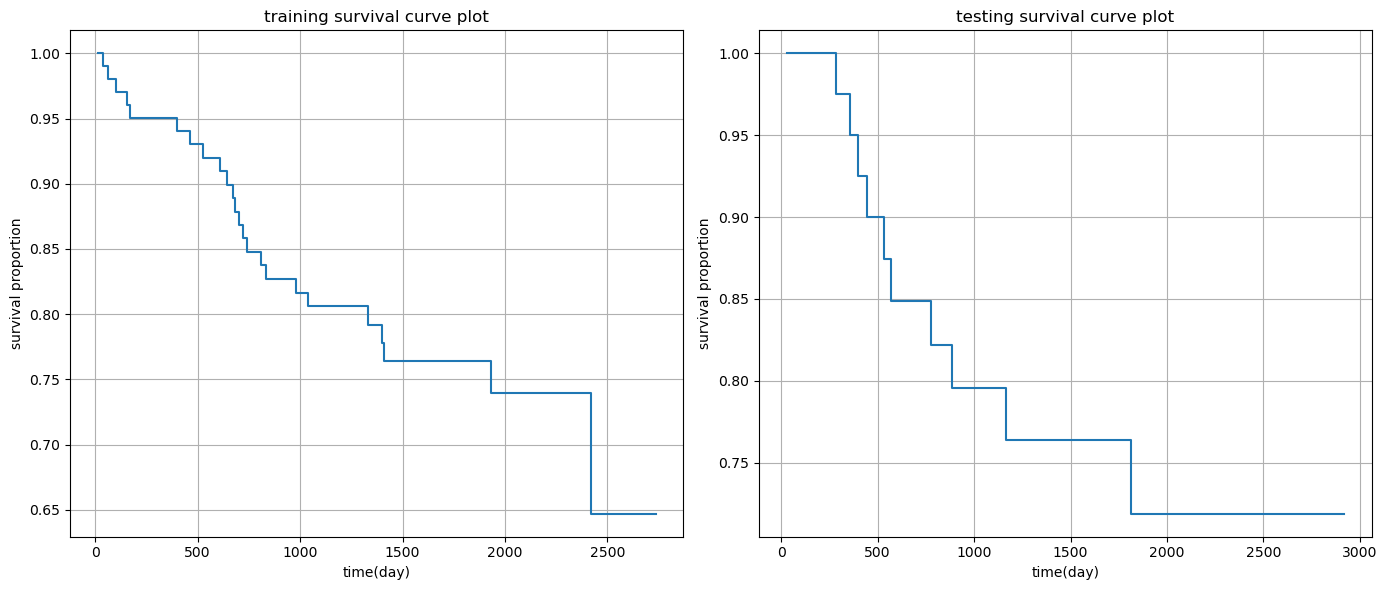

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

time_train, survival_prob_train = kaplan_meier_estimator(y_train['event'], y_train['time'])
ax1.step(time_train, survival_prob_train, where="post")
ax1.set_title("training survival curve plot")
ax1.set_xlabel("time(day)")
ax1.set_ylabel("survival proportion")
ax1.grid(True)

time_test, survival_prob_test = kaplan_meier_estimator(y_test['event'], y_test['time'])
ax2.step(time_test, survival_prob_test, where="post")
ax2.set_title("testing survival curve plot")
ax2.set_xlabel("time(day)")
ax2.set_ylabel("survival proportion")
ax2.grid(True)

plt.tight_layout()
plt.show()

In [100]:
np.savez(
    'survival_data_split.npz',
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

In [102]:
y_train

array([(False, 1127.), (False,   51.), (False, 1645.), (False,  593.),
       (False, 2518.), ( True,  808.), ( True,  741.), (False, 1988.),
       ( True,  723.), ( True,  462.), (False, 1114.), (False, 1959.),
       ( True,  527.), ( True,  103.), ( True,   38.), (False, 1231.),
       (False, 2241.), ( True,   63.), (False, 1134.), (False, 2154.),
       (False, 1167.), (False, 1456.), ( True,  608.), (False, 1468.),
       ( True, 1038.), (False, 2190.), (False, 1534.), (False, 1121.),
       (False, 1884.), (False, 1982.), (False,   43.), (False, 1848.),
       (False, 1056.), (False, 2168.), (False, 2023.), ( True, 1400.),
       (False, 2075.), ( True,  170.), (False, 1861.), (False,  175.),
       ( True,  643.), (False, 2320.), (False, 1119.), ( True,  704.),
       (False, 1975.), (False, 1858.), (False, 2612.), ( True, 1934.),
       (False, 1236.), (False, 1838.), (False, 1634.), ( True,  670.),
       (False, 1077.), (False,   89.), (False, 1409.), ( True, 1411.),
      

In [101]:
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

# Save each set to its own CSV file
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train_df.to_csv('y_train.csv', index=False)
y_test_df.to_csv('y_test.csv', index=False)

In [103]:
y_train_df

,event,time
0,False,1127.0
1,False,51.0
2,False,1645.0
3,False,593.0
4,False,2518.0
...,...,...
100,True,2421.0
101,False,1480.0
102,False,1562.0
103,False,1929.0


In [ ]:
# X_scaled.to_csv(f'{file_path}/X_scaled.csv')


#### 1. Random Forest (RF)
RF is often used for classification or regression, where we use it as a classification model to predict whether an event will occur (event).

`n_estimators`: The number of trees

`random_state`: to ensure that the result can be reproduced


In [57]:
from sksurv.ensemble import RandomSurvivalForest

rsf_model = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf_model.fit(X_train, y_train)

risk_scores_rsf = rsf_model.predict(X)

risk_scores_train = rsf_model.predict(X_train)
risk_scores_test = rsf_model.predict(X_test)

print(len(risk_scores_rsf)) ## 150 predicted outcomes

surv_funcs_train = rsf_model.predict_survival_function(X_train)
surv_funcs_test = rsf_model.predict_survival_function(X_test)

print(f"Number of survival functions for the training set: {len(surv_funcs_train)}")
print(f"Number of survival functions for the testing set: {len(surv_funcs_test)}")

150
Number of survival functions for the training set: 105
Number of survival functions for the testing set: 45


In [52]:
c_index_train = concordance_index_censored(
    y_train['event'], y_train['time'], risk_scores_train
)[0]
c_index_test = concordance_index_censored(
    y_test['event'], y_test['time'], risk_scores_test
)[0]
print(f"C-index for the training set: {c_index_train:.4f}")
print(f"C-index for the testing set: {c_index_test:.4f}")

C-index for the training set: 0.9670
C-index for the testing set: 0.6541


In [63]:
time_point = 365 * 5

print('------ Time-Dependent AUC ------')
auc_train = concordance_index_ipcw(
    y_train, y_train, risk_scores_train, tau=time_point
)[0]
auc_test = concordance_index_ipcw(
    y_train, y_test, risk_scores_test, tau=time_point
)[0]

print(f"training set in {time_point} days has Time-Dependent AUC: {auc_train:.4f}")
print(f"testing set in {time_point} days has Time-Dependent AUC: {auc_test:.4f}")

print('------ Brier Score ------')
surv_funcs_train = rsf_model.predict_survival_function(X_train)
surv_funcs_test = rsf_model.predict_survival_function(X_test)

surv_prob_train = np.array([f(time_point) for f in surv_funcs_train])
surv_prob_test = np.array([f(time_point) for f in surv_funcs_test])

score_train = brier_score(y_train, y_train, surv_prob_train, time_point)[1]
score_test = brier_score(y_train, y_test, surv_prob_test, time_point)[1]

print(f"training set in {time_point} days has Brier Score: {score_train}")
print(f"testing set in {time_point} days has Brier Score: {score_test}")

------ Time-Dependent AUC ------
training set in 1825 days has Time-Dependent AUC: 0.9709
testing set in 1825 days has Time-Dependent AUC: 0.6780
------ Brier Score ------
training set in 1825 days has Brier Score: [0.04566054]
testing set in 1825 days has Brier Score: [0.15685395]


In [ ]:
# rs_median = np.median(risk_scores_rsf)
# # print(rs_median) ## 3.829275793650794
# rs_grps = np.where(risk_scores_rsf > rs_median, 'High_rs', 'Low_rs')
# survival_val['Risk_Score'] = rs_grps

# print(survival_val)
# kmf = KaplanMeierFitter()
# high_risk_grp = survival_val[survival_val['Risk_Score'] == 'High_rs']
# kmf.fit(durations = high_risk_grp['Time to event if any (days)'], event_observed = high_risk_grp['IDFS Event'], label='High Risk Score')
# ax = kmf.plot_survival_function()

# low_risk_grp = survival_val[survival_val['Risk_Score'] == 'Low_rs']
# kmf.fit(durations = low_risk_grp['Time to event if any (days)'], event_observed = low_risk_grp['IDFS Event'], label='Low Risk Score')
# kmf.plot_survival_function(ax=ax)

# plt.title('KaplanMeierFitter for Groups by Median')
# plt.xlabel('Time to events(days)')
# plt.ylabel('Survival Probability')
# plt.grid(True)
# plt.show()


(np.float64(83.10284106650921), np.float64(6.627200593394291e-18))


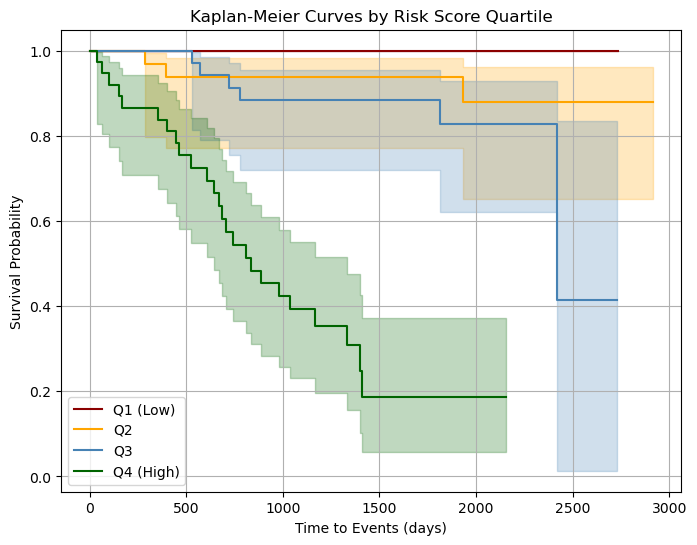

In [50]:
quartiles = np.quantile(risk_scores_rsf, [0.25, 0.5, 0.75])
def categorize_risk(score):
    if score <= quartiles[0]:
        return 'Q1 (Low)'
    elif score <= quartiles[1]:
        return 'Q2'
    elif score <= quartiles[2]:
        return 'Q3'
    else:
        return 'Q4 (High)'

df = survival_val.copy()
df['Risk_Group_Quartile'] = np.vectorize(categorize_risk)(risk_scores_rsf)

y_structured = Surv.from_arrays(
    event=df['IDFS Event'].values.astype(bool),
    time=df['Time to event if any (days)'].values
)
group_labels = df['Risk_Group_Quartile'].values
results = compare_survival(y_structured, group_labels)
print(results)

kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(8, 6))

for group_name, color in zip(['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'], ['darkred', 'orange', 'steelblue', 'darkgreen']):
    group_data = df[df['Risk_Group_Quartile'] == group_name]
    kmf.fit(durations=group_data['Time to event if any (days)'], event_observed=group_data['IDFS Event'], label=group_name)
    kmf.plot_survival_function(ax=ax, color=color)
plt.title('Kaplan-Meier Curves by Risk Score Quartile')
plt.xlabel('Time to Events (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

#### 2. Cox Regression (CoxPH)

Cox Proportional risk model, which is the standard survival analysis model

Note: The model of the lifelines library usually requires a single DataFrame that contains all the data (features, time, and events).

instead of separate X and y, and it is insensitive to data scaling

In [76]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

In [71]:
train_df_cph = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(y_train)], axis=1)
test_df_cph = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(y_test)], axis=1)

duration_col = 'time'
event_col = 'event'

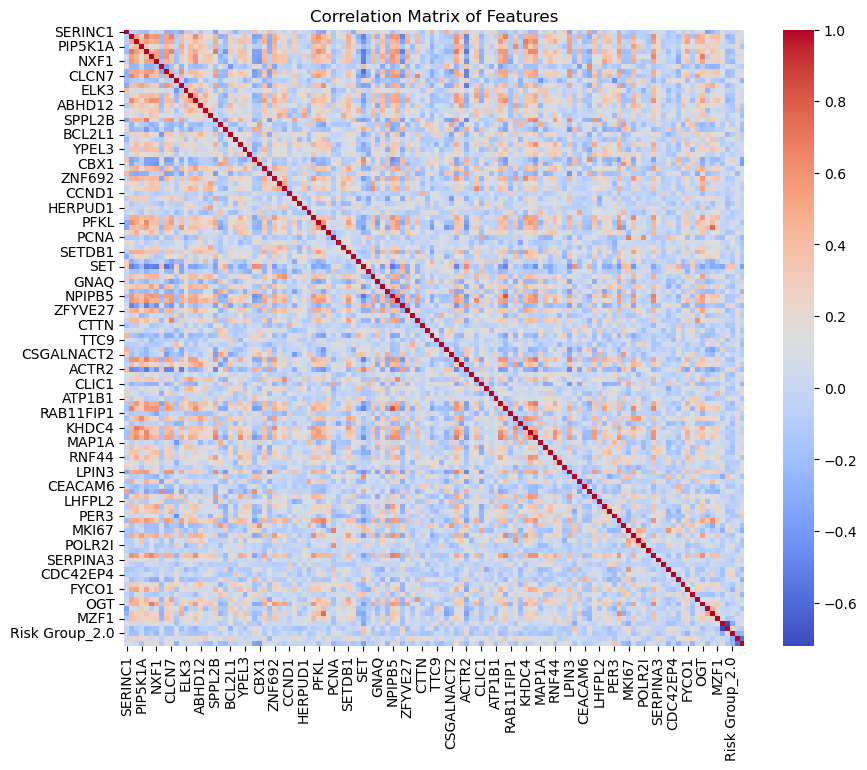

high correlation pairs:
Series([], dtype: bool)


In [74]:
corr_matrix = X_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Features')
plt.show()

high_corr_pairs = (corr_matrix.abs() > 0.9) & (corr_matrix.abs() < 1.0)
high_corr_indices = high_corr_pairs.stack()[high_corr_pairs.stack()]

print("high correlation pairs:")
print(high_corr_indices)

In [93]:
non_numeric_cols = train_df_cph.select_dtypes(exclude=[np.float64, np.int64]).columns

print(non_numeric_cols)
if not non_numeric_cols.empty:
    print(train_df_cph[non_numeric_cols].head())
else:
    print("No numeric cols")


bool_cols = train_df_cph.select_dtypes(include='bool').columns

if not bool_cols.empty:
    print(train_df_cph[bool_cols].sum())
else:
    print("No bool types cols")

Index(['Menospausal Status_Pre-Menopausal', 'Risk Group_2.0', 'Risk Group_3.0',
       'Risk Group_4.0', 'event'],
      dtype='object')
   Menospausal Status_Pre-Menopausal  Risk Group_2.0  Risk Group_3.0  \
0                              False           False           False   
1                               True           False            True   
2                              False           False           False   
3                              False           False           False   
4                              False           False            True   

   Risk Group_4.0  event  
0            True  False  
1           False  False  
2            True  False  
3            True  False  
4           False  False  
Menospausal Status_Pre-Menopausal    28
Risk Group_2.0                       12
Risk Group_3.0                       44
Risk Group_4.0                       33
event                                24
dtype: int64


In [ ]:
# cph = CoxPHFitter(penalizer=0.01)

cph = CoxPHFitter()
cph.fit(train_df_cph, duration_col=duration_col, event_col=event_col)

risk_scores_train = cph.predict_partial_hazard(X_train)
risk_scores_test = cph.predict_partial_hazard(X_test)

/Users/yuzimeng/anaconda3/envs/ml_env/lib/python3.9/site-packages/lifelines/utils/__init__.py:990: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)


ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

In [77]:
# Calculate C-index for the training set
c_index_train = concordance_index(
    train_df_cph[duration_col], risk_scores_train, train_df_cph[event_col]
)

# Calculate C-index for the testing set
c_index_test = concordance_index(
    test_df_cph[duration_col], risk_scores_test, test_df_cph[event_col]
)

print(f"C-index for training set: {c_index_train:.4f}")
print(f"C-index for testing set: {c_index_test:.4f}")

C-index for training set: 0.0005
C-index for testing set: 0.2296


In [80]:
# Define the time points in days
time_points = [365, 365 * 3, 365 * 5]

# Convert y_train and y_test to NumPy structured arrays if not already
# This is a good practice for sksurv metric functions
y_train_sk = Surv.from_arrays(event=y_train['event'], time=y_train['time'])
y_test_sk = Surv.from_arrays(event=y_test['event'], time=y_test['time'])

print("\n--- Time-Dependent AUC ---")
for t in time_points:
    auc_test = concordance_index_ipcw(y_train_sk, y_test_sk, risk_scores_test, tau=t)[0]
    print(f"Time-Dependent AUC at {t} days: {auc_test:.4f}")

print("\n--- Brier Score ---")
# Predict survival probabilities for the specific time points
survival_probs_test = cph.predict_survival_function(X_test, times=time_points)

for i, t in enumerate(time_points):
    # The brier_score function needs the original data for weighting
    b_score_test = brier_score(y_train_sk, y_test_sk, survival_probs_test.iloc[i], t)[1]
    print(f"Brier Score at {t} days: {b_score_test}")
    
print("\n--- Training Set Time-Dependent AUC ---")
for t in time_points:
    auc_train = concordance_index_ipcw(y_train_sk, y_train_sk, risk_scores_train, tau=t)[0]
    print(f"Time-Dependent AUC at {t} days: {auc_train:.4f}")

# And the original code for the test set
print("\n--- Testing Set Time-Dependent AUC ---")
for t in time_points:
    auc_test = concordance_index_ipcw(y_train_sk, y_test_sk, risk_scores_test, tau=t)[0]
    print(f"Time-Dependent AUC at {t} days: {auc_test}")


--- Time-Dependent AUC ---
Time-Dependent AUC at 365 days: 0.7273
Time-Dependent AUC at 1095 days: 0.7586
Time-Dependent AUC at 1825 days: 0.7659

--- Brier Score ---
Brier Score at 365 days: [0.05578261]
Brier Score at 1095 days: [0.23522922]
Brier Score at 1825 days: [0.20008462]

--- Training Set Time-Dependent AUC ---
Time-Dependent AUC at 365 days: 1.0000
Time-Dependent AUC at 1095 days: 0.9994
Time-Dependent AUC at 1825 days: 0.9995

--- Testing Set Time-Dependent AUC ---
Time-Dependent AUC at 365 days: 0.7272727272727273
Time-Dependent AUC at 1095 days: 0.7586207361697266
Time-Dependent AUC at 1825 days: 0.7658572565623101


In [ ]:
# survival_df = survival_val[['Time to event if any (days)','IDFS Event']]
# lifelines_df = pd.concat([X,survival_df], axis=1)
# print(lifelines_df.columns)

# cph = CoxPHFitter()
# cph.fit(lifelines_df, duration_col='Time to event if any (days)', event_col='IDFS Event')
# cph.print_summary()

Index(['SERINC1', 'WDR6', 'INTS3', 'PIP5K1A', 'TMEM259', 'ARGLU1', 'NXF1',
       'SNX3', 'KAT2A', 'CLCN7',
       ...
       'EEF1D', 'USP36', 'MZF1', 'Age', 'Menospausal Status_Pre-Menopausal',
       'Risk Group_2.0', 'Risk Group_3.0', 'Risk Group_4.0',
       'Time to event if any (days)', 'IDFS Event'],
      dtype='object', length=128)


In [ ]:
# X.to_csv(file_path + '/scaled_genes_age_meno_risk.csv')

In [ ]:
# survival_df.to_csv(file_path + '/survival_time_event.csv')

/Users/yuzimeng/anaconda3/envs/ml_env/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


<lifelines.CoxPHFitter: fitted with 150 total observations, 116 right-censored observations>
             duration col = 'Time to event if any (days)'
                event col = 'IDFS Event'
      baseline estimation = breslow
   number of observations = 150
number of events observed = 34
   partial log-likelihood = -123.67
         time fit was run = 2025-09-02 16:44:46 UTC

---
                                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                          
SERINC1                            0.07      1.07      1.37           -2.62            2.75                0.07               15.61
WDR6                               0.63      1.88      1.23           -1.78            3.04                0.17               20.96
INTS3                             -0.02      0.98      1.33           -2.63            2.60                0.07               13.42
PIP5K1A                           -0.65      0.52      0.95           -2.51            1.21                0.08                3.35
TMEM259                            0.00      1.00      1.53           -3.00            3.00                0.05               20.06
ARGLU1                            -0.12      0.89      0.99           -2.07            1.82                0.13                6.19
NXF1                               0.38      1.46      1.02           -1.63            2.38                0.20               10.82
SNX3                              -0.06      0.94      0.80           -1.63            1.51                0.20                4.54
KAT2A                             -0.18      0.84      0.96           -2.07            1.71                0.13                5.55
CLCN7                             -0.10      0.91      1.34           -2.72            2.53                0.07               12.51
AHCY                               0.01      1.01      0.89           -1.73            1.74                0.18                5.72
CSNK1D                             0.11      1.11      0.90           -1.66            1.87                0.19                6.48
ELK3                               0.39      1.47      0.92           -1.41            2.19                0.24                8.89
SLC25A28                           0.54      1.72      1.18           -1.77            2.86                0.17               17.39
DELE1                             -0.46      0.63      1.49           -3.37            2.46                0.03               11.65
ABHD12                            -0.15      0.86      1.04           -2.20            1.89                0.11                6.63
PARP4                             -0.27      0.76      0.74           -1.73            1.18                0.18                3.26
SLA                               -0.47      0.62      0.84           -2.12            1.18                0.12                3.24
SPPL2B                            -0.09      0.91      1.37           -2.78            2.59                0.06               13.38
NREP                               0.34      1.40      1.38           -2.37            3.04                0.09               20.94
RANBP9                             0.29      1.34      1.08           -1.82            2.40                0.16               11.01
BCL2L1                            -0.39      0.68      0.98           -2.32            1.54                0.10                4.66
LGALS3BP                           0.21      1.23      0.82           -1.40            1.82                0.25                6.17
FKBP8                             -0.25      0.78      0.93           -2.08            1.58                0.13                4.83
YPEL3                             -0.28      0.76      1.08           -2.39            1.84                0.09                6.27
WWC3                              -0.27      0.77   

2.1 Lasso-Cox

In [ ]:
# cph = CoxPHFitter(penalizer=0.01, l1_ratio=1.0)
# cph.fit(lifelines_df, duration_col='Time to event if any (days)', event_col='IDFS Event')
# # cph.print_summary()
# print(len(cph.params_[cph.params_ != 0].index.tolist()))

<lifelines.CoxPHFitter: fitted with 150 total observations, 116 right-censored observations>
             duration col = 'Time to event if any (days)'
                event col = 'IDFS Event'
                penalizer = 0.01
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 150
number of events observed = 34
   partial log-likelihood = -106.70
         time fit was run = 2025-09-02 20:27:39 UTC

---
                                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                          
SERINC1                            0.00      1.00      0.00           -0.00            0.00                1.00                1.00
WDR6                               0.00      1.00      0.00           -0.00            0.00                1.00                1.00
INTS3                              0.00      1.00      0.00           -0.00            0.00                1.00                1.00
PIP5K1A                           -0.35      0.71      0.61           -1.55            0.85                0.21                2.34
TMEM259                            0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ARGLU1                             0.00      1.00      0.00           -0.00            0.00                1.00                1.00
NXF1                               0.58      1.78      0.57           -0.54            1.70                0.58                5.46
SNX3                              -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
KAT2A                             -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
CLCN7                             -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
AHCY                               0.00      1.00      0.00           -0.00            0.00                1.00                1.00
CSNK1D                            -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ELK3                               0.64      1.90      0.48           -0.29            1.58                0.75                4.84
SLC25A28                           0.16      1.17      0.51           -0.84            1.16                0.43                3.19
DELE1                             -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ABHD12                            -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
PARP4                             -0.12      0.89      0.40           -0.89            0.66                0.41                1.93
SLA                               -0.30      0.74      0.53           -1.34            0.74                0.26                2.09
SPPL2B                            -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
NREP                               0.00      1.00      0.00           -0.00            0.00                1.00                1.00
RANBP9                             0.73      2.08      0.44           -0.13            1.59                0.88                4.91
BCL2L1                            -0.68      0.51      0.49           -1.65            0.29                0.19                1.34
LGALS3BP                          -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
FKBP8                              0.00      1.00      0.00           -0.00            0.00                1.00                1.00
YPEL3                             -0.00      1.00      0.00           -0.00            0.00                1.00        

126


#### 3.Aalen's Additive Model

Unlike the Cox model, it assumes that the effects of covariates are additive rather than multipliative.

In [67]:
print(lifelines_df[['Menospausal Status_Pre-Menopausal','Risk Group_2.0', 'Risk Group_3.0', 'Risk Group_4.0']].corr())
print(selected_genes.corr())

                                   Menospausal Status_Pre-Menopausal  \
Menospausal Status_Pre-Menopausal                           1.000000   
Risk Group_2.0                                              0.175712   
Risk Group_3.0                                             -0.027845   
Risk Group_4.0                                             -0.065291   

                                   Risk Group_2.0  Risk Group_3.0  \
Menospausal Status_Pre-Menopausal        0.175712       -0.027845   
Risk Group_2.0                           1.000000       -0.303547   
Risk Group_3.0                          -0.303547        1.000000   
Risk Group_4.0                          -0.228665       -0.624695   

                                   Risk Group_4.0  
Menospausal Status_Pre-Menopausal       -0.065291  
Risk Group_2.0                          -0.228665  
Risk Group_3.0                          -0.624695  
Risk Group_4.0                           1.000000  
          SERINC1      WDR6     I

In [70]:
highly_correlated_genes = []
for i in range(len(lifelines_df.columns)-7):
    for j in range(i):
        if abs(lifelines_df.iloc[i, j]) > 0.999:
            colname_i = lifelines_df.columns[i]
            colname_j = lifelines_df.columns[j]
            highly_correlated_genes.append(colname_i)
            print(f"发现共线性的基因：{colname_i} 和 {colname_j}")
            
cleaned_gene_names = [g for g in lifelines_df if g not in highly_correlated_genes]

发现共线性的基因：TMEM259 和 SERINC1
发现共线性的基因：NXF1 和 ARGLU1
发现共线性的基因：SNX3 和 SERINC1
发现共线性的基因：SNX3 和 PIP5K1A
发现共线性的基因：SNX3 和 ARGLU1
发现共线性的基因：CLCN7 和 SERINC1
发现共线性的基因：CLCN7 和 WDR6
发现共线性的基因：CLCN7 和 INTS3
发现共线性的基因：CLCN7 和 ARGLU1
发现共线性的基因：AHCY 和 PIP5K1A
发现共线性的基因：AHCY 和 ARGLU1
发现共线性的基因：AHCY 和 NXF1
发现共线性的基因：AHCY 和 KAT2A
发现共线性的基因：CSNK1D 和 NXF1
发现共线性的基因：ELK3 和 SERINC1
发现共线性的基因：ELK3 和 WDR6
发现共线性的基因：ELK3 和 TMEM259
发现共线性的基因：ELK3 和 KAT2A
发现共线性的基因：ELK3 和 CLCN7
发现共线性的基因：ELK3 和 AHCY
发现共线性的基因：SLC25A28 和 PIP5K1A
发现共线性的基因：SLC25A28 和 ARGLU1
发现共线性的基因：SLC25A28 和 ELK3
发现共线性的基因：DELE1 和 SERINC1
发现共线性的基因：DELE1 和 INTS3
发现共线性的基因：DELE1 和 ARGLU1
发现共线性的基因：DELE1 和 ELK3
发现共线性的基因：ABHD12 和 AHCY
发现共线性的基因：ABHD12 和 ELK3
发现共线性的基因：PARP4 和 SERINC1
发现共线性的基因：PARP4 和 PIP5K1A
发现共线性的基因：PARP4 和 TMEM259
发现共线性的基因：PARP4 和 ARGLU1
发现共线性的基因：PARP4 和 NXF1
发现共线性的基因：PARP4 和 KAT2A
发现共线性的基因：PARP4 和 CLCN7
发现共线性的基因：PARP4 和 CSNK1D
发现共线性的基因：PARP4 和 DELE1
发现共线性的基因：SLA 和 SERINC1
发现共线性的基因：SLA 和 AHCY
发现共线性的基因：SLA 和 ELK3
发现共线性的基因：SPPL2B 和 INTS3
发现共线性的基因：SPPL2B 和

In [75]:
from lifelines import AalenAdditiveFitter

aaf = AalenAdditiveFitter(fit_intercept=False)

print(len(cleaned_gene_names))
print(lifelines_df[cleaned_gene_names])

aaf.fit(lifelines_df, duration_col='Time to event if any (days)', event_col='IDFS Event')
aaf.print_summary()

15
            SERINC1      WDR6     INTS3   PIP5K1A    ARGLU1     KAT2A  \
Sample_ID                                                               
0DTPRC    -0.425901 -0.533689  1.076433  1.373374  0.548149  0.369720   
0DTPIS    -0.842216 -2.010823  0.201605 -1.484453 -2.339565 -1.847972   
0DTPIJ     0.773591  0.860349  3.603064  2.229372  2.174995  1.542498   
0DTPGY    -0.027900  0.467411  0.717093  0.183670  1.448364  1.586918   
0DTPRG     1.018772  0.206696  0.868532  0.234172 -0.029080 -0.086533   
...             ...       ...       ...       ...       ...       ...   
0E0EHZ     1.378122  0.782234  0.549350  0.276737 -0.200818 -0.052374   
0E0EK8     0.561573  2.782921  0.533306  0.014385  2.576060  0.469260   
0E0EHO    -0.960538 -0.824700 -0.896063 -0.458063 -0.571474 -0.805082   
0E0EGY     0.320247 -0.211579  0.266266  0.172177 -1.324928 -0.867108   
0E0EGR    -0.099602  2.173725 -0.280822  0.234123  1.267503 -0.334121   

               NREP     FKBP8   Age  Menospausa

<lifelines.AalenAdditiveFitter: fitted with 150 total observations, 116 right-censored observations>
             duration col = 'Time to event if any (days)'
                event col = 'IDFS Event'
       number of subjects = 150
number of events observed = 34
         time fit was run = 2025-09-01 17:28:16 UTC

---
Empty DataFrame
Columns: []
Index: [SERINC1, WDR6, INTS3, PIP5K1A, TMEM259, ARGLU1, NXF1, SNX3, KAT2A, CLCN7, AHCY, CSNK1D, ELK3, SLC25A28, DELE1, ABHD12, PARP4, SLA, SPPL2B, NREP, RANBP9, BCL2L1, LGALS3BP, FKBP8, YPEL3, WWC3, KIF5B, CBX1, JADE2, UBE2J1, ZNF692, RESF1, TRAF1, CCND1, PCP2, SLC25A23, HERPUD1, KLF10, SUGP2, PFKL, GGA3, ARHGAP40, PCNA, SRSF1, C1QA, SETDB1, CPNE1, MCFD2, SET, SF3B6, TEP1, GNAQ, TUBG2, ITGB1, NPIPB5, PRKD2, MTPN, ZFYVE27, RPL10, MGRN1, CTTN, ENC1, PCYOX1, TTC9, RPS5, CD164, CSGALNACT2, HOOK2, NCOA5, ACTR2, PLK2, TMEM140, CLIC1, IFITM2, TMEM101, ATP1B1, CABIN1, NPIPB3, RAB11FIP1, UBAP2L, SPON1, KHDC4, ILF3, SIN3B, MAP1A, VPS37B, ARHGEF37, RNF44, NEURL1B, LRP2, LPIN3, BAZ1B, SLC25A25, CEACAM6, SEC63, TNPO2, LHFPL2, PHF8, EEF2K, PER3, ...]
---
Concordance = 0.55

#### 4.Survival Support Vector Model

Apply the principles of support vector machines (SVMs) to survival data. It aims to find a hyperplane that maximizes the difference between the time of occurrence of an event and the time of review.

In [82]:
from sksurv.svm import FastSurvivalSVM
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

In [83]:
time_points = [365, 365 * 3, 365 * 5]

for threshold in time_points:
    print(f"======================================================")
    print(f"      Evaluating SVM at {threshold} days ({threshold/365:.0f}-year)")
    print(f"======================================================")

    # 2. Create the Binary Target Variable for Training
    # A patient is a '1' if they had an event before or at the threshold.
    y_train_binary = np.where(
        (y_train['time'] <= threshold) & (y_train['event'] == True), 
        1, 
        0
    )

    # 3. Create the Binary Target Variable for Testing
    # This must be done separately for the test set.
    y_test_binary = np.where(
        (y_test['time'] <= threshold) & (y_test['event'] == True), 
        1, 
        0
    )
    
    # 4. Train and Evaluate the SVM Model
    # Use the new binary target variables for each time point.
    svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)
    svm_model.fit(X_train, y_train_binary)
    y_pred = svm_model.predict(X_test)

    # 5. Print the Results
    print(f"Test set accuracy: {accuracy_score(y_test_binary, y_pred):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test_binary, y_pred))
    print(f"Number of support vectors per class: {svm_model.n_support_}")
    print("\n")

      Evaluating SVM at 365 days (1-year)
Test set accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.33      0.50      0.40         2

    accuracy                           0.93        45
   macro avg       0.65      0.73      0.68        45
weighted avg       0.95      0.93      0.94        45

Number of support vectors per class: [27  5]


      Evaluating SVM at 1095 days (3-year)
Test set accuracy: 0.71

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.82        37
           1       0.27      0.38      0.32         8

    accuracy                           0.71        45
   macro avg       0.56      0.58      0.57        45
weighted avg       0.75      0.71      0.73        45

Number of support vectors per class: [38 18]


      Evaluating SVM at 1825 days (5-year)
Test set accuracy: 0.69

Cla

In [ ]:


# lifelines_df['Risk_Category'] = np.where(
#     (lifelines_df['Time to event if any (days)'] <= survival_threshold) & 
#     (lifelines_df['IDFS Event'] == 1), 
#     1, 
#     0
# )
# X = lifelines_df.drop(columns=['Time to event if any (days)', 'IDFS Event', 'Risk_Category'])
# y = lifelines_df['Risk_Category']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train) ## X is feature training, y is risk category

y_pred = svm_model.predict(X_test)
# risk_scores_svm = svm_model.predict(X)
# risk_scores_svm[:5]

print("--- SVM model evaluation report ---")
print(f"accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nclassification report:")
print(classification_report(y_test, y_pred))
print(f"support vector: {svm_model.n_support_}")

--- SVM model evaluation report ---
accuracy: 0.76

classification report:
              precision    recall  f1-score   support

           0       0.91      0.79      0.85        39
           1       0.27      0.50      0.35         6

    accuracy                           0.76        45
   macro avg       0.59      0.65      0.60        45
weighted avg       0.83      0.76      0.78        45

support vector: [30 17]


In [105]:
y_train.value_counts()

Risk_Category
0    84
1    21
Name: count, dtype: int64

#### 5.XGBoost for survival version

Consists of a decision tree and is an extension of Random Forest in survival analysis. It predicts an individual's survival function by averaging the survival tree on multiple subsamples.

In [84]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [86]:
time_points = [365, 365 * 3, 365 * 5]

params = {
    'objective': 'binary:logistic', # For binary classification
    'eval_metric': 'logloss',       # Evaluation metric
    'eta': 0.1,                     # Learning rate
    'max_depth': 3,                 # Maximum tree depth
    'seed': 42,
    'scale_pos_weight': 4           # Handles class imbalance
}

for threshold in time_points:
    print(f"======================================================")
    print(f"      Evaluating XGBoost at {threshold} days ({threshold/365:.0f}-year)")
    print(f"======================================================")

    # 1. Create the Binary Target Variable for Training
    # A patient is a '1' if they had an event before or at the threshold.
    y_train_binary = np.where(
        (y_train['time'] <= threshold) & (y_train['event'] == True), 
        1, 
        0
    )

    # 2. Create the Binary Target Variable for Testing
    # This must be done separately for the test set.
    y_test_binary = np.where(
        (y_test['time'] <= threshold) & (y_test['event'] == True), 
        1, 
        0
    )
    
    # 3. Train and Evaluate the XGBoost Model
    # We set scale_pos_weight to handle class imbalance, which is common in survival data.
    scale_pos_weight = np.sum(y_train_binary == 0) / np.sum(y_train_binary == 1)
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42)
    xgb_model.fit(X_train, y_train_binary)
    y_pred = xgb_model.predict(X_test)

    # 4. Print the Results
    print(f"Test set accuracy: {accuracy_score(y_test_binary, y_pred):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test_binary, y_pred))
    print("\n")

      Evaluating XGBoost at 365 days (1-year)
Test set accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        43
           1       0.00      0.00      0.00         2

    accuracy                           0.93        45
   macro avg       0.48      0.49      0.48        45
weighted avg       0.91      0.93      0.92        45



      Evaluating XGBoost at 1095 days (3-year)
Test set accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        37
           1       0.00      0.00      0.00         8

    accuracy                           0.80        45
   macro avg       0.41      0.49      0.44        45
weighted avg       0.67      0.80      0.73        45



      Evaluating XGBoost at 1825 days (5-year)
Test set accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

   

In [ ]:
survival_threshold = 1095 ## set as three years
lifelines_df['Risk_Category'] = np.where(
    (lifelines_df['Time to event if any (days)'] <= survival_threshold) & 
    (lifelines_df['IDFS Event'] == 1), 
    1, 
    0
)
X = lifelines_df.drop(columns=['Time to event if any (days)', 'IDFS Event', 'Risk_Category']) ## 129 - 3 = 126
y = lifelines_df['Risk_Category'] ## 1

In [102]:
from sksurv.util import Surv
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic', # 二元分类
    'eval_metric': 'logloss',       # 评估指标
    'eta': 0.1,                     # 学习率
    'max_depth': 3,                 # 树的最大深度
    'seed': 42,
    'scale_pos_weight': 4
}

bst = xgb.train(params, dtrain, num_boost_round=100)

y_pred_proba = bst.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int) # 将概率转换为类别

print("--- XGBoost Evaluation Report ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

feature_importances = bst.get_score(importance_type='weight')
print("\nFeature Important (in Weight):")
print(feature_importances)

# xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
# xgb_clf.fit(X_scaled, y['IDFS Event'])

# event_probabilities = xgb_clf.predict_proba(X_scaled)[:, 1]

# print(event_probabilities[:5])

--- XGBoost Evaluation Report ---
Accuracy: 0.69

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81        39
           1       0.10      0.17      0.12         6

    accuracy                           0.69        45
   macro avg       0.48      0.47      0.47        45
weighted avg       0.76      0.69      0.72        45


Feature Important (in Weight):
{'SERINC1': 2.0, 'WDR6': 1.0, 'PIP5K1A': 1.0, 'TMEM259': 2.0, 'NXF1': 1.0, 'SNX3': 1.0, 'KAT2A': 6.0, 'AHCY': 2.0, 'CSNK1D': 1.0, 'ABHD12': 2.0, 'PARP4': 6.0, 'SLA': 1.0, 'SPPL2B': 15.0, 'NREP': 1.0, 'BCL2L1': 1.0, 'FKBP8': 3.0, 'WWC3': 31.0, 'JADE2': 1.0, 'UBE2J1': 1.0, 'ZNF692': 4.0, 'TRAF1': 1.0, 'CCND1': 1.0, 'SLC25A23': 27.0, 'KLF10': 3.0, 'PCNA': 6.0, 'SRSF1': 2.0, 'SF3B6': 3.0, 'TEP1': 2.0, 'GNAQ': 1.0, 'ITGB1': 9.0, 'MTPN': 1.0, 'ZFYVE27': 4.0, 'RPL10': 1.0, 'CTTN': 8.0, 'ENC1': 20.0, 'PCYOX1': 9.0, 'TTC9': 17.0, 'RPS5': 2.0, 'CSGALNACT2': 7.0, 'NCOA5': 

In [101]:
print(y_train.value_counts())

Risk_Category
0    84
1    21
Name: count, dtype: int64


Model Evaluation in Same Criterias

In [87]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
# Assuming all models (cph, rsf_model, svm_model, xgb_model) are already fitted

time_points = [365, 365 * 3, 365 * 5]

for threshold in time_points:
    print(f"======================================================")
    print(f"      Comparing Models at {threshold} days ({threshold/365:.0f}-year)")
    print(f"======================================================")
    
    # Define the ground truth for this time point
    y_true_binary = np.where(
        (y_test['time'] <= threshold) & (y_test['event'] == True), 
        1, 
        0
    )

    # --- 1. Get Predictions from SVM ---
    svm_pred = svm_model.predict(X_test)
    print("\n--- SVM Classification Report ---")
    print(classification_report(y_true_binary, svm_pred, zero_division=0))

    # --- 2. Get Predictions from XGBoost ---
    xgb_pred = xgb_model.predict(X_test)
    print("\n--- XGBoost Classification Report ---")
    print(classification_report(y_true_binary, xgb_pred, zero_division=0))

    # --- 3. Get Predictions from Random Survival Forest ---
    surv_funcs = rsf_model.predict_survival_function(X_test)
    rsf_probs = np.array([f(threshold) for f in surv_funcs])
    rsf_pred = np.where(rsf_probs < 0.5, 1, 0) # Convert survival prob to binary class
    print("\n--- RSF as a Classifier Report ---")
    print(classification_report(y_true_binary, rsf_pred, zero_division=0))

    # --- 4. Get Predictions from CoxPH ---
    surv_probs_cph = cph.predict_survival_function(X_test, times=[threshold]).iloc[0]
    cph_pred = np.where(surv_probs_cph < 0.5, 1, 0)
    print("\n--- CoxPH as a Classifier Report ---")
    print(classification_report(y_true_binary, cph_pred, zero_division=0))
    
    print("\n")

      Comparing Models at 365 days (1-year)

--- SVM Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.79      0.87        43
           1       0.10      0.50      0.17         2

    accuracy                           0.78        45
   macro avg       0.54      0.65      0.52        45
weighted avg       0.93      0.78      0.84        45


--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        43
           1       0.20      0.50      0.29         2

    accuracy                           0.89        45
   macro avg       0.59      0.70      0.61        45
weighted avg       0.94      0.89      0.91        45


--- RSF as a Classifier Report ---
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        43
           1       0.00      0.00      0.00         2

    accuracy                